In [382]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sharmadeepankaj/customer-churn-of-powerco-ltd")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\anajr\.cache\kagglehub\datasets\sharmadeepankaj\customer-churn-of-powerco-ltd\versions\1


In [383]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)   # 모든 컬럼 표시
pd.set_option('display.width', None)         # 줄바꿈 없이 전체 폭 사용
pd.set_option('display.max_colwidth', None)  # 컬럼 내용 생략 안 함print(df)

cust_df = pd.read_csv('data/client_data.csv')
cust_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [384]:
price_df = pd.read_csv('data/price_data.csv')
price_df.head(20)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.000000,0.000000,44.266931,0.000000,0.000000
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.000000,0.000000,44.266931,0.000000,0.000000
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.000000,0.000000,44.266931,0.000000,0.000000
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.000000,0.000000,44.266931,0.000000,0.000000
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.000000,0.000000,44.266931,0.000000,0.000000
5,038af19179925da21a25619c5a24b745,2015-06-01,0.149626,0.000000,0.000000,44.266930,0.000000,0.000000
6,038af19179925da21a25619c5a24b745,2015-07-01,0.150321,0.000000,0.000000,44.444710,0.000000,0.000000
7,038af19179925da21a25619c5a24b745,2015-08-01,0.145859,0.000000,0.000000,44.444710,0.000000,0.000000
8,038af19179925da21a25619c5a24b745,2015-09-01,0.145859,0.000000,0.000000,44.444710,0.000000,0.000000
9,038af19179925da21a25619c5a24b745,2015-10-01,0.145859,0.000000,0.000000,44.444710,0.000000,0.000000


| 컬럼명(한글) | 컬럼명(영어) | 설명(한글) | 분포 | 데이터 타입 |
|---|---|---|---|---|
| 고객사 ID | id | 고객사 고유 식별자 | 14,606개 모두 고유값 | object |
| 판매 채널 | channel_sales | 고객이 유입된 판매 채널 코드 | 3개 주요 범주 (약 46% / 28% / 26%) | object |
| 연간 전기 소비량 | cons_12m | 지난 12개월간 전기 소비량 | 강한 우측 치우침, max ≈ 6.21M | int64 |
| 연간 가스 소비량 | cons_gas_12m | 지난 12개월간 가스 소비량 | 강한 우측 치우침, max ≈ 4.15M | int64 |
| 전월 전기 소비량 | cons_last_month | 지난달 전기 소비량 | 우측 치우침, max ≈ 771K | int64 |
| 계약 활성일 | date_activ | 계약이 시작된 날짜 | 2003-05-09 ~ 2014-09-01 | object |
| 계약 종료일 | date_end | 계약이 종료된 날짜 | 2016-01-28 ~ 2017-06-13 | object |
| 상품 수정일 | date_modif_prod | 상품이 마지막으로 수정된 날짜 | 2003-05-09 ~ 2016-01-29 | object |
| 계약 갱신일 | date_renewal | 다음 계약 갱신 예정일 | 2013-06-26 ~ 2016-01-28 | object |
| 예상 전기 소비량(12개월) | forecast_cons_12m | 향후 12개월 예상 전기 소비량 | 대부분 저값, max ≈ 82.9K | float64 |
| 예상 전기 소비량(1년) | forecast_cons_year | 향후 1년 예상 전기 소비량 | 대부분 저값, max ≈ 175K | int64 |
| 예상 에너지 할인 | forecast_discount_energy | 향후 적용될 할인 금액 | 0~30 구간 집중 | float64 |
| 예상 계량기 임대료 | forecast_meter_rent_12m | 향후 12개월 계량기 임대료 | 0~30 구간 집중 | float64 |
| 비수기 에너지 가격 | forecast_price_energy_off_peak | 비수기 에너지 단가 예측 | 0~600 구간 집중 | float64 |
| 피크 에너지 가격 | forecast_price_energy_peak | 피크 시간대 에너지 단가 예측 | 0.11~0.18 집중 | float64 |
| 비수기 전력 가격 | forecast_price_pow_off_peak | 비피크 시간대 전력 단가 | 0.08~0.12 집중 | float64 |
| 가스 고객 여부 | has_gas | 가스 상품 가입 여부 | True 18% / False 82% | object |
| 유료 소비량 | imp_cons | 실제 청구 기준 소비량 | 우측 치우침, max ≈ 15K | float64 |
| 전력 총마진 | margin_gross_pow_ele | 전력 구독 총 마진 | 0~375 범위 집중 | float64 |
| 전력 순마진 | margin_net_pow_ele | 전력 구독 순 마진 | 총마진과 유사 분포 | float64 |
| 활성 상품 수 | nb_prod_act | 활성화된 상품 및 서비스 수 | 1~2개 구간 집중 | int64 |
| 총 순마진 | net_margin | 고객 전체 순마진 | 극단적 우측 치우침 | float64 |
| 가입 연수 | num_years_antig | 고객 가입 후 경과 연수 | 2~7년 구간 집중 | int64 |
| 가입 캠페인 | origin_up | 최초 가입 캠페인 코드 | 3개 주요 그룹 | object |
| 계약 전력량 | pow_max | 계약된 최대 전력량 | 3~320 범위 | float64 |
| 이탈 여부 | churn | 향후 3개월 내 이탈 여부 | 1 약 10% / 0 약 90% | int64 |

| 컬럼명(한글) | 컬럼명(영어) | 설명(한글) | 분포 | 데이터 타입 |
|---|---|---|---|---|
| 고객사 ID | id | 고객사(회사) 고유 식별자 | 16,096개 고객, 중복 존재 | object |
| 가격 기준일 | price_date | 가격이 적용되는 기준 날짜 | 2015-01-01 ~ 2015-12-01 (월 단위) | object |
| 비수기 에너지 변동가 | price_off_peak_var | 비수기(1구간) 에너지 변동 가격 | 0.10~0.16 집중, max ≈ 0.28 | float64 |
| 피크 에너지 변동가 | price_peak_var | 피크(2구간) 에너지 변동 가격 | 다수 0값, 유효값 0.08~0.12 | float64 |
| 중간피크 에너지 변동가 | price_mid_peak_var | 중간피크(3구간) 에너지 변동 가격 | 대부분 0, 일부 0.06~0.10 | float64 |
| 비수기 전력 고정가 | price_off_peak_fix | 비수기(1구간) 전력 고정 가격 | 40~46 집중, max ≈ 59.4 | float64 |
| 피크 전력 고정가 | price_peak_fix | 피크(2구간) 전력 고정 가격 | 다수 0, 일부 24~26 / 35~36 | float64 |
| 중간피크 전력 고정가 | price_mid_peak_fix | 중간피크(3구간) 전력 고정 가격 | 다수 0, 일부 16~17 | float64 |

In [385]:
print(cust_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [386]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


In [387]:
cust_df.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056,152.786896,24.565121,24.562517,1.292346,189.264522,4.997809,18.135136,0.097152
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988,341.369366,20.231172,20.230280,0.709774,311.798130,1.611749,13.534743,0.296175
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.300000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,0.000000,14.280000,14.280000,1.000000,50.712500,4.000000,12.500000,0.000000
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378,37.395000,21.640000,21.640000,1.000000,112.530000,5.000000,13.856000,0.000000
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378,193.980000,29.880000,29.880000,1.000000,243.097500,6.000000,19.172500,0.000000
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,15042.790000,374.640000,374.640000,32.000000,24570.650000,13.000000,320.000000,1.000000


In [388]:
price_df.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
std,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


In [389]:
price_df['price_date'].unique()

array(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
       '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
       '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
      dtype=object)

In [390]:
# datetime으로 변환
price_df["price_date"] = pd.to_datetime(price_df["price_date"])

# 정렬
price_df = price_df.sort_values(["id", "price_date"])

# 현재 컬럼
price_cols = [
    "price_off_peak_var", "price_peak_var", "price_mid_peak_var",
    "price_off_peak_fix", "price_peak_fix", "price_mid_peak_fix"
]

price_feat = (
    price_df
    .groupby("id")[price_cols]
    .agg(["mean", "last", "std"])
)

# 컬럼명 정리
price_feat.columns = [
    f"{col}_{stat}" for col, stat in price_feat.columns
]

price_merge = price_feat.reset_index()

price_merge

,id,price_off_peak_var_mean,price_off_peak_var_last,price_off_peak_var_std,price_peak_var_mean,price_peak_var_last,price_peak_var_std,price_mid_peak_var_mean,price_mid_peak_var_last,price_mid_peak_var_std,price_off_peak_fix_mean,price_off_peak_fix_last,price_off_peak_fix_std,price_peak_fix_mean,price_peak_fix_last,price_peak_fix_std,price_mid_peak_fix_mean,price_mid_peak_fix_last,price_mid_peak_fix_std
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.119906,0.003976,0.103794,0.101673,0.001989,0.073160,0.073719,0.001368,40.701732,40.728885,6.341481e-02,24.421038,24.43733,0.038049,16.280694,16.291555,0.025366
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.143943,0.002197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.385450,44.444710,8.753223e-02,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.201280,0.026008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.319710,45.944710,7.723930e-01,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.113068,0.005049,0.098292,0.095385,0.002580,0.069032,0.069409,0.000403,40.647427,40.728885,8.507958e-02,24.388455,24.43733,0.051048,16.258971,16.291555,0.034032
4,00114d74e963e47177db89bc70108537,0.147926,0.145440,0.002202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.266930,44.266930,5.908392e-07,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.112488,0.026238,0.115125,0.094804,0.020548,0.080780,0.068829,0.012503,40.896427,40.728885,1.749923e-01,24.637456,24.43733,0.209025,16.507972,16.291555,0.226040
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.145047,0.002098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.311375,44.444710,8.040373e-02,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.151399,0.003044,0.129497,0.126871,0.002447,0.094842,0.091394,0.004310,41.160171,41.228885,8.491973e-02,24.895768,24.93733,0.051364,16.763569,16.791555,0.034586
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.118175,0.004600,0.103499,0.100491,0.002397,0.073735,0.074516,0.000471,40.606699,40.728885,7.368063e-02,24.364017,24.43733,0.044209,16.242678,16.291555,0.029474


In [391]:
df = pd.merge(cust_df, price_merge, on='id', how='left')
print(df)

                                     id                     channel_sales  \
0      24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1      d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2      764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3      bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4      149d57cf92fc41cf94415803a877cb4b                           MISSING   
...                                 ...                               ...   
14601  18463073fb097fc0ac5d3e040f356987  foosdfpfkusacimwkcsosbicdxkicaua   
14602  d0a6f71671571ed83b2645d23af6de00  foosdfpfkusacimwkcsosbicdxkicaua   
14603  10e6828ddd62cbcf687cb74928c4c2d2  foosdfpfkusacimwkcsosbicdxkicaua   
14604  1cf20fd6206d7678d5bcafd28c53b4db  foosdfpfkusacimwkcsosbicdxkicaua   
14605  563dde550fd624d7352f3de77c0cdfcd                           MISSING   

       cons_12m  cons_gas_12m  cons_last_month  date_activ    date_end  \
0

In [392]:
drop_cols = [
    "id", "channel_sales", "origin_up",
    "date_activ", "date_end", "date_modif_prod", "date_renewal"
]

num_df = df.drop(columns=drop_cols)


num_df.dtypes[num_df.dtypes == "object"]

num_only = df.select_dtypes(include="number")
corr = num_only.corr(method="spearman")

corr

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,price_off_peak_var_mean,price_off_peak_var_last,price_off_peak_var_std,price_peak_var_mean,price_peak_var_last,price_peak_var_std,price_mid_peak_var_mean,price_mid_peak_var_last,price_mid_peak_var_std,price_off_peak_fix_mean,price_off_peak_fix_last,price_off_peak_fix_std,price_peak_fix_mean,price_peak_fix_last,price_peak_fix_std,price_mid_peak_fix_mean,price_mid_peak_fix_last,price_mid_peak_fix_std
cons_12m,1.000000,0.160806,0.707032,0.694671,0.428597,-0.023709,0.287928,-0.286003,0.322951,-0.364294,0.410905,-0.094043,-0.093887,0.118601,0.688099,-0.010412,0.350056,-0.002551,-0.314687,-0.281411,0.194029,0.308669,0.321073,0.261764,0.288616,0.297901,0.335469,-0.285071,-0.321984,-0.120245,0.316439,0.310795,0.262354,0.319026,0.317001,0.261435
cons_gas_12m,0.160806,1.000000,0.147987,0.137266,0.091387,0.005091,0.057946,-0.048058,0.064644,-0.074614,0.092540,-0.026359,-0.026283,0.864880,0.133930,-0.001806,0.075938,-0.022411,-0.060746,-0.045648,0.033638,0.056326,0.064043,0.039306,0.058535,0.062599,0.072083,-0.060132,-0.069370,-0.037103,0.065750,0.063192,0.051726,0.069715,0.067723,0.052763
cons_last_month,0.707032,0.147987,1.000000,0.443088,0.770927,-0.018031,0.350992,-0.284418,0.377308,-0.369781,0.759288,-0.001591,-0.001596,0.109250,0.444694,0.008718,0.350604,-0.012018,-0.302850,-0.279228,0.239387,0.365784,0.378467,0.299604,0.344469,0.354278,0.374719,-0.287129,-0.334367,-0.082906,0.364704,0.364885,0.318581,0.367442,0.369838,0.317483
forecast_cons_12m,0.694671,0.137266,0.443088,1.000000,0.508364,0.051576,0.257705,-0.249353,0.267103,-0.324942,0.515419,-0.175371,-0.175358,0.124813,0.950025,-0.059650,0.339583,0.007514,-0.275133,-0.240384,0.194109,0.254987,0.264039,0.229761,0.239631,0.243892,0.299944,-0.233214,-0.263795,-0.135108,0.274379,0.263030,0.203043,0.279252,0.272513,0.201336
forecast_cons_year,0.428597,0.091387,0.770927,0.508364,1.000000,0.014000,0.426005,-0.370869,0.435116,-0.443927,0.986705,-0.011329,-0.011403,0.072039,0.515532,-0.013098,0.425308,0.005227,-0.383304,-0.365445,0.331617,0.427262,0.435234,0.352968,0.429404,0.433010,0.458738,-0.363924,-0.403460,-0.106306,0.449072,0.447969,0.386351,0.453509,0.454786,0.384633
forecast_discount_energy,-0.023709,0.005091,-0.018031,0.051576,0.014000,1.000000,-0.003308,0.274723,0.090459,0.149067,0.033434,0.240706,0.239711,0.143653,0.017620,-0.082715,0.003325,0.017809,0.238040,0.274227,0.190355,0.072956,0.087736,0.072618,0.048950,0.049174,0.039293,0.153596,0.145566,0.134620,0.039335,0.044734,0.043591,0.042199,0.047482,0.041649
forecast_meter_rent_12m,0.287928,0.057946,0.350992,0.257705,0.426005,-0.003308,1.000000,-0.608144,0.689925,-0.625446,0.397380,0.115827,0.115760,0.034116,0.293192,0.006291,0.659542,0.041252,-0.612820,-0.597328,0.577250,0.691612,0.692787,0.559262,0.760442,0.754883,0.746923,-0.578126,-0.601482,-0.122704,0.774630,0.779258,0.682375,0.767429,0.772003,0.680906
forecast_price_energy_off_peak,-0.286003,-0.048058,-0.284418,-0.249353,-0.370869,0.274723,-0.608144,1.000000,-0.470100,0.713709,-0.320575,0.041078,0.040789,0.012071,-0.325157,-0.035283,-0.669577,-0.033090,0.953609,0.984253,-0.517990,-0.483492,-0.474919,-0.410623,-0.689001,-0.685125,-0.711864,0.673868,0.689259,0.202797,-0.733554,-0.751629,-0.656594,-0.719781,-0.737718,-0.654680
forecast_price_energy_peak,0.322951,0.064644,0.377308,0.267103,0.435116,0.090459,0.689925,-0.470100,1.000000,-0.730926,0.400213,0.175854,0.175995,0.064778,0.326003,-0.016632,0.706446,0.035761,-0.487785,-0.462525,0.666396,0.969478,0.992329,0.767701,0.888364,0.886487,0.823887,-0.677335,-0.707281,-0.109674,0.836179,0.842708,0.749627,0.852478,0.858302,0.752106
forecast_price_pow_off_peak,-0.364294,-0.074614,-0.369781,-0.324942,-0.443927,0.149067,-

In [393]:
# 날짜 컬럼 변환
date_cols = ["date_activ", "date_end", "date_renewal"]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# 계약 시작부터 종료까지 기간
df["tenure_days"] = (df["date_end"] - df["date_activ"]).dt.days

# 음수/이상값 처리: 음수면 0으로 클리핑
df["tenure_days"] = df["tenure_days"].clip(lower=0)

drop_cols = [
    'id'
    ,'channel_sales'
    ,'origin_up'
    ,'price_off_peak_var_mean'
    ,'price_peak_var_mean'
    ,'price_mid_peak_var_mean'
    ,'price_off_peak_fix_mean'
    ,'price_peak_fix_mean'
    ,'price_mid_peak_fix_mean'
    ,'forecast_cons_12m'
    ,'forecast_cons_year'
    ,'forecast_discount_energy'
    ,'margin_gross_pow_ele'
    ,'date_activ'
    ,'date_end'
    ,'date_modif_prod'
    ,'date_renewal'
]
df = df.drop(columns=drop_cols)



In [394]:
df

,cons_12m,cons_gas_12m,cons_last_month,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,price_off_peak_var_last,price_off_peak_var_std,price_peak_var_last,price_peak_var_std,price_mid_peak_var_last,price_mid_peak_var_std,price_off_peak_fix_last,price_off_peak_fix_std,price_peak_fix_last,price_peak_fix_std,price_mid_peak_fix_last,price_mid_peak_fix_std,tenure_days
0,0,54946,0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,2,678.99,3,43.648,1,0.146033,0.007829,0.085483,0.005126,0.000000,0.020983,44.266930,1.050136e+00,0.000000,7.039226,0.000000,4.692817,1096
1,4660,0,0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,1,18.89,6,13.800,0,0.147600,0.002212,0.000000,0.024677,0.000000,0.000000,44.444710,8.040385e-02,0.000000,0.000000,0.000000,0.000000,2566
2,544,0,0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,1,6.60,6,13.856,0,0.167798,0.002396,0.088409,0.000506,0.000000,0.000000,44.444710,8.753223e-02,0.000000,0.000000,0.000000,0.000000,2192
3,1584,0,0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,1,25.46,6,13.200,0,0.148586,0.002317,0.000000,0.000000,0.000000,0.000000,44.444710,8.040349e-02,0.000000,0.000000,0.000000,0.000000,2192
4,4425,0,526,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,1,47.98,6,19.800,0,0.119906,0.003847,0.101673,0.001885,0.073719,0.001588,40.728885,7.368135e-02,24.437330,0.044209,16.291555,0.029473,2245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14601,32270,47940,0,18.57,0.138305,0.000000,44.311378,t,0.00,27.88,2,381.77,4,15.000,0,0.140172,0.003897,0.000000,0.000000,0.000000,0.000000,44.444710,9.154352e-02,0.000000,0.000000,0.000000,0.000000,1445
14602,7223,0,181,144.03,0.100167,0.091892,58.995952,f,15.94,0.00,1,90.34,3,6.000,1,0.102352,0.003669,0.093181,0.001863,0.070990,0.000128,59.173468,1.165389e-01,36.490689,0.071868,8.367731,0.016479,1461
14603,1844,0,179,129.60,0.116900,0.100015,40.606701,f,18.05,39.84,1,20.38,4,15.935,1,0.119906,0.003976,0.101673,0.001989,0.073719,0.001368,40.728885,6.341481e-02,24.437330,0.038049,16.291555,0.025366,1460
14604,131,0,0,7.18,0.145711,0.000000,44.311378,f,0.00,13.08,1,0.96,3,11.000,0,0.147600,0.002212,0.000000,0.024677,0.000000,0.000000,44.444710,8.040379e-02,0.000000,0.000000,0.000000,0.000000,1461


In [395]:
df['has_gas'].unique()

array(['t', 'f'], dtype=object)

In [396]:
df["has_gas"] = df['has_gas'].map({"t": 1, "f": 0})

<Axes: >

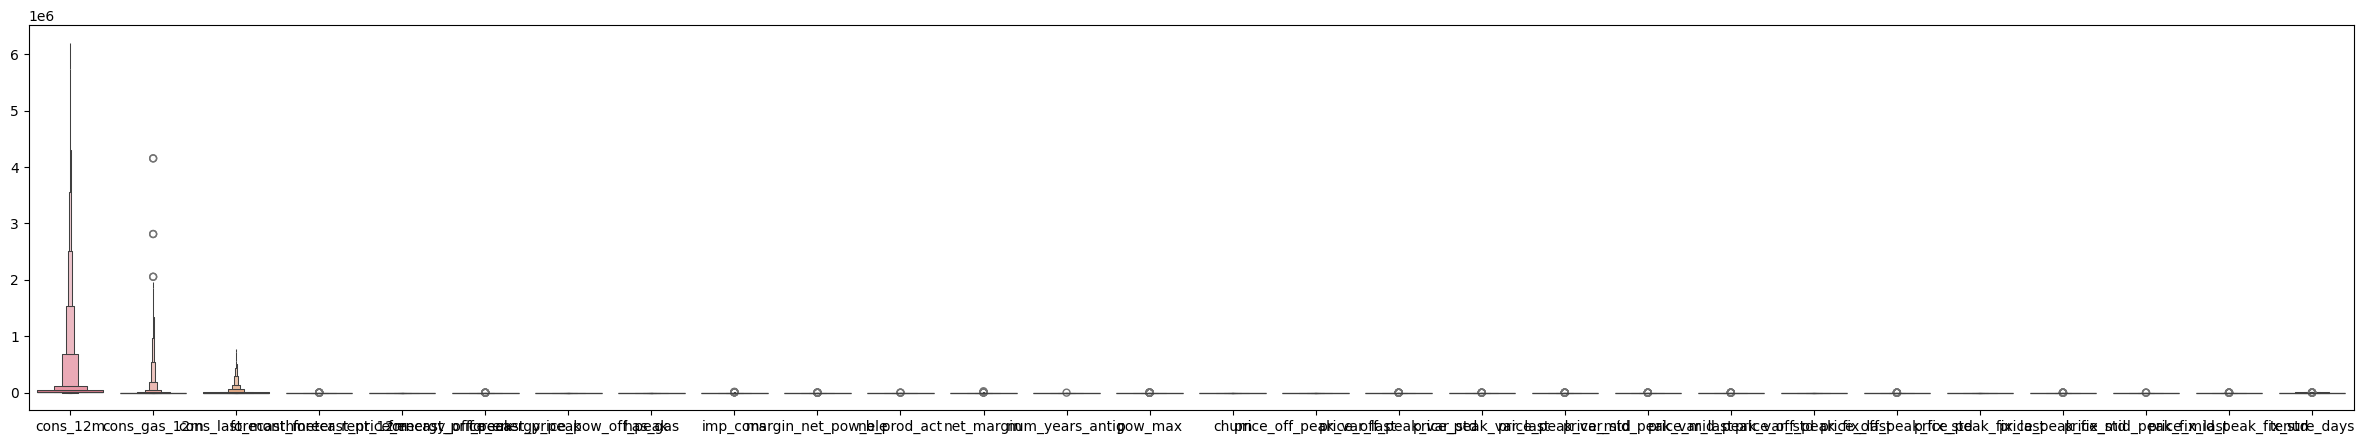

In [397]:
plt.figure(figsize=(30,5))

sns.boxenplot(df)


```
1. 도메인 불가능 값
가격 < 0
소비량 < 0
계약 기간 음수

그래프에서 안 보임


2. 단일 값이 전체를 지배
1~2개 값이 분산의 90% 차지

그 정도는 아님
```

In [398]:
target = 'churn'
X = df.drop(columns=[target])   # 입력변수(특성)
y = df[target]                  # 타겟 변수(인기도)

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=42,
    stratify=y                      # 클래스가 불균형해서 비율을 맞춰서 분배하였다
)

### 이탈 데이터는 변수 간 비선형 상관관계가 강해, 이를 잘 포착하는 LightGBM을 사용해 초기 feature 중요도를 산출


클래스 불균형으로 train/test split은 운이 작용할 수 있어서
StratifiedKFold CV를 사용하여 평균성능을 확인했음.

In [399]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

auc_scores = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        class_weight="balanced",
        random_state=42
    )

    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_prob)
    auc_scores.append(auc)

    print(f"Fold {fold} AUC: {auc:.4f}")

print("\nCV AUC Mean :", np.mean(auc_scores))

Fold 1 AUC: 0.7080
Fold 2 AUC: 0.6892
Fold 3 AUC: 0.6734
Fold 4 AUC: 0.6745
Fold 5 AUC: 0.6836

CV AUC Mean : 0.6857480844426934


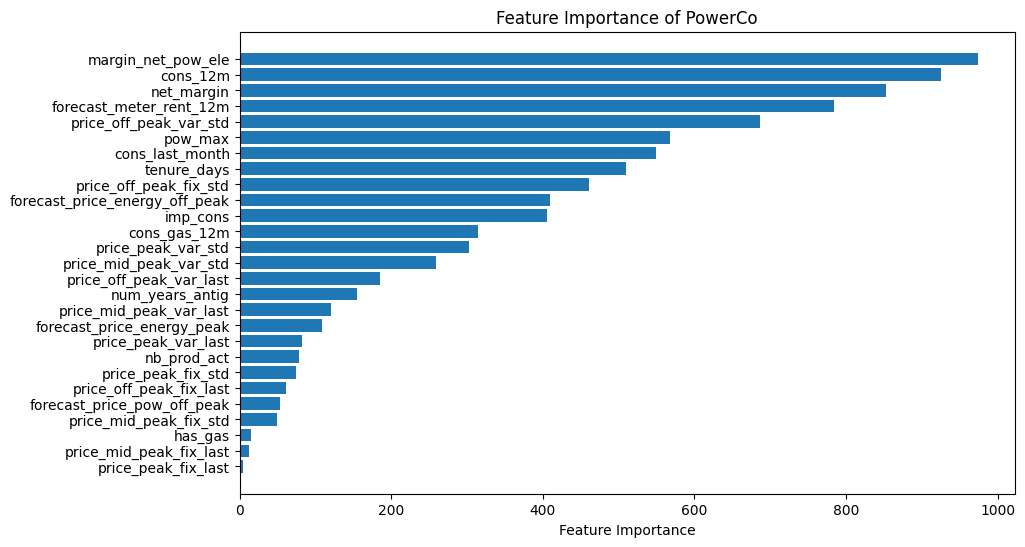

In [400]:
model_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature':features,'Importance':model_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=True)

plt.figure(figsize=(10,6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel('Feature Importance')
plt.title('Feature Importance of PowerCo')
plt.show()


## 하위 30%의 중요성을 가진 피쳐들을 drop

In [401]:
drop = [
    'price_peak_fix_last'
    ,'price_mid_peak_fix_last'
    ,'has_gas'
    ,'price_mid_peak_fix_std'
    ,'forecast_price_pow_off_peak'
    ,'price_off_peak_fix_last'
    ,'price_peak_fix_std'
    ,'nb_prod_act'
    ,'price_peak_var_last'
    ,'forecast_price_energy_peak'
    ,'price_mid_peak_var_last'
]

df_reduced = df.drop(columns=drop)

In [ ]:
# 다시 학습
X = df_reduced.drop(columns=["churn"])
y = df_reduced["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [403]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

auc_scores = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        class_weight="balanced",
        random_state=42
    )

    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_prob)
    auc_scores.append(auc)

    print(f"Fold {fold} AUC: {auc:.4f}")

print("\nCV AUC Mean :", np.mean(auc_scores))

Fold 1 AUC: 0.7068
Fold 2 AUC: 0.6830
Fold 3 AUC: 0.6771
Fold 4 AUC: 0.6749
Fold 5 AUC: 0.6826

CV AUC Mean : 0.6848822514037768
